## Hi-ChIP analysis plots

In [11]:
import os,sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import sparse

In [142]:
import matplotlib
def remove_x_axis(ax):
    ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_xlabel('');
    
def remove_y_axis(ax):
    ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_ylabel('');

### Read results

In [4]:
os.listdir('/home/jovyan/mount/gdrive/DGD_multiomics/data

['Figures_patchwork_A4',
 'Paper structure',
 'Preliminary abstract',
 'TcellActivation_EDA',
 'data',
 'figures',
 'figures_patchwork',
 'multiDGD_validation.ipynb']

In [6]:
outdir = '/home/jovyan/mount/gdrive/DGD_multiomics/data/HiChIP_data/model_results/'
os.listdir(outdir)

['CD69_hg38_baseline_correlation.csv',
 'CD69_hg38_hichip_dgd_aligned_locations.csv',
 'CLEC16A_hg38_baseline_correlation.csv',
 'CLEC16A_hg38_hichip_dgd_aligned_locations.csv',
 'ID2_hg38_baseline_correlation.csv',
 'ID2_hg38_hichip_dgd_aligned_locations.csv',
 'ID2_hg38_hichip_dgd_aligned_locations_old.csv']

In [26]:
genes_oi_coords = {
    'CLEC16A':'chr16:11038421-11276043',
    'CD69':'chr12:9905082-9913497',
    'CD19':'chr16:28943292-28950663',
    'ID2':'chr2:8822186-8824591'
}

In [35]:
pip install pyranges

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 9.9 MB/s eta 0:00:00:00:0100:01
  Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 9.9 MB/s eta 0:00:00:00:0100:01m
Note: you may need to restart the kernel to use updated packages.


In [36]:
import pyranges as pr

def _pyranges_from_strings(pos_list):
    """
    Function to create pyranges for a `pd.Series` of strings
    (borrowed from SEAcells https://github.com/dpeerlab/SEACells)
    """
    # Chromosome and positions
    chr = pos_list.str.split(':').str.get(0)
    start = pd.Series(pos_list.str.split(':').str.get(1)
                      ).str.split('-').str.get(0)
    end = pd.Series(pos_list.str.split(':').str.get(1)
                    ).str.split('-').str.get(1)

    # Create ranges
    gr = pr.PyRanges(chromosomes=chr, starts=start, ends=end)
    return gr

In [391]:
from matplotlib.ticker import MaxNLocator

def plot_virtual4C_gene_locus(dgd_df, ymax=100):
    '''
    Visualization of locus and enhancer
    '''
    plt.rcParams['font.size'] = 12
    plt.rcParams['figure.figsize'] = 9,5.5
    fig,axs = plt.subplots(nrows=3, ncols=1, height_ratios=(1,10, 7))
    
    gene_name = dgd_df['gene_name'].tolist()[0]
    coords = f"{dgd_df['chromosome'].tolist()[0]}:{dgd_df['position'].min()}-{dgd_df['position'].max()}"
        
    # plot gene coords
    gene_gr = _pyranges_from_strings(pd.Series(dgd_df['gene_coords'][0])).as_df()
    axs[0].plot([gene_gr['Start'][0], gene_gr['End'][0]],[1,1], color='black', linewidth=10); ## vertical
    axs[0].set_xlim(dgd_df.position.min(),dgd_df.position.max());
    axs[0].text(gene_gr['Start'][0]-50000, 1, gene_name, fontsize=12, ha='right', va='center', color='black')
#     print(gene_gr['Start'][0])
    
    remove_x_axis(axs[0])
    remove_y_axis(axs[0])
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['bottom'].set_visible(False)
    axs[0].spines['left'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    
    # Plot HiChip signal
    signal_gene_df = dgd_df[dgd_df.method == 'HiChIP'].reset_index()
    signal_df = signal_gene_df[signal_gene_df['cell type'] == 'negative']
    axs[1].step(signal_df.position, signal_df.signal, label='HCAMSC (Neg. HiChIP)', color='#a6cee3');
    signal_df = signal_gene_df[signal_gene_df['cell type'] == 'positive']
    axs[1].step(signal_df.position, signal_df.signal, label='Naive CD4+ T (Pos. HiChIP)', color='#33a02c');
    axs[1].yaxis.set_major_locator(MaxNLocator(nbins=4))
    axs[1].set_xlim(dgd_df.position.min(),dgd_df.position.max());

    # plot viewpoint coordinates
#     print(signal_df.viewpoint.values[0])
#     axs[1].axvline(x=signal_df.viewpoint.values[0], color='r', linewidth=1, linestyle='--'); ## vertical
#     axs[1].axvline(x=signal_df.viewpoint.values[0] + 10000, color='r', linewidth=1, linestyle='--'); ## vertical
    axs[1].set_ylabel("EIS");
    axs[1].set_ylim(0,ymax);
    axs[1].legend(loc='upper left',frameon=False)
    remove_x_axis(axs[1])
    
    # Plot DGD prediction
    signal_gene_df = dgd_df[(dgd_df.method == 'multiDGD') & (dgd_df['cell type'] == 'CD4+ T naive')].reset_index()
    signal_gene_df['signal'] = min_max_scale(signal_gene_df.signal)
    axs[2].step(signal_gene_df.position, signal_gene_df.signal, color='#990000', label='CD4+ T naive');
    axs[2].set_ylabel("multiDGD $\Delta$\n(min-max scaled)");
    axs[2].yaxis.set_major_locator(MaxNLocator(nbins=2))
    axs[2].xaxis.set_major_locator(MaxNLocator(nbins=4))
    axs[2].ticklabel_format(style='plain')
    axs[2].set_xlim(dgd_df.position.min(),dgd_df.position.max());
    plt.ylim(0,1.01);
    plt.xlabel(f'Genomic coordinate ({coords})');
    plt.subplots_adjust(wspace=0.2, hspace=0.03)  # Reduce the width and height spacing
    

In [383]:
def min_max_scale(x):
    return((x - min(x)) / (max(x) - min(x)))



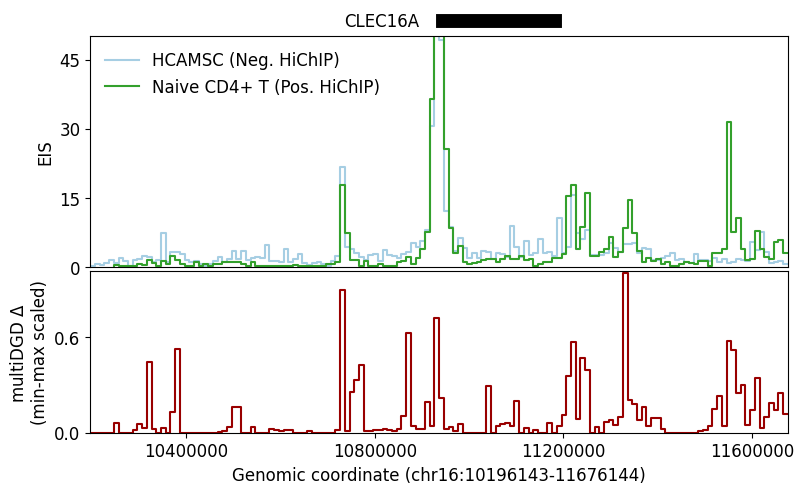

In [392]:
figdir = '/home/jovyan/mount/gdrive/DGD_multiomics/plot_outputs/'
gene = 'CLEC16A'
eis_df = pd.read_csv(f'/home/jovyan/mount/gdrive/DGD_multiomics/data/HiChIP_data/EIS_signal_{gene}promoter.hg38.csv')
corr_df = pd.read_csv(outdir + f'{gene}_hg38_baseline_correlation.csv')
dgd_df = pd.read_csv(outdir + f'{gene}_hg38_hichip_dgd_aligned_locations.csv')
dgd_df['position'] = (dgd_df.position * 10e5).astype(int)
dgd_df['gene_name'] = gene
dgd_df['gene_coords'] = eis_df['gene_coords'][0]
dgd_df['chromosome'] = eis_df['chromosome'][0]
dgd_df['viewpoint'] = eis_df['viewpoint'][0]
plot_virtual4C_gene_locus(dgd_df.reset_index(), ymax=50);
plt.savefig(figdir + f'{gene}_tracks.pdf')

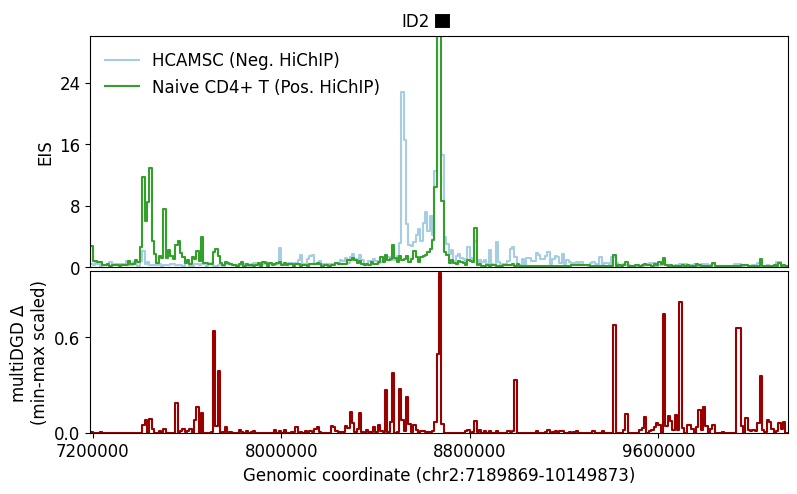

In [393]:
gene = 'ID2'
eis_df = pd.read_csv(f'/home/jovyan/mount/gdrive/DGD_multiomics/data/HiChIP_data/EIS_signal_{gene}promoter.hg38.csv')
corr_df = pd.read_csv(outdir + f'{gene}_hg38_baseline_correlation.csv')
dgd_df = pd.read_csv(outdir + f'{gene}_hg38_hichip_dgd_aligned_locations.csv')
dgd_df['position'] = (dgd_df.position * 10e5).astype(int)
dgd_df['gene_name'] = gene
dgd_df['gene_coords'] = eis_df['gene_coords'][0]
dgd_df['chromosome'] = eis_df['chromosome'][0]
dgd_df['viewpoint'] = int(eis_df['gene_coords'][0].split(":")[1].split('-')[0])
plot_virtual4C_gene_locus(dgd_df.reset_index(), ymax=30);
plt.savefig(figdir + f'{gene}_tracks.pdf')


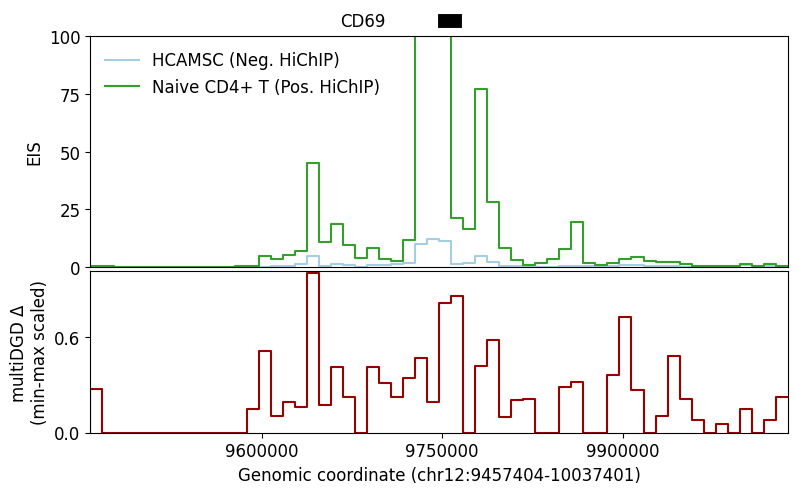

In [394]:
gene = 'CD69'
eis_df = pd.read_csv(f'/home/jovyan/mount/gdrive/DGD_multiomics/data/HiChIP_data/EIS_signal_{gene}promoter.hg38.csv')
corr_df = pd.read_csv(outdir + f'{gene}_hg38_baseline_correlation.csv')
dgd_df = pd.read_csv(outdir + f'{gene}_hg38_hichip_dgd_aligned_locations.csv')
dgd_df['position'] = (dgd_df.position * 10e5).astype(int)
dgd_df['gene_name'] = gene
dgd_df['gene_coords'] = eis_df['gene_coords'][0]
dgd_df['chromosome'] = eis_df['chromosome'][0]
dgd_df['viewpoint'] = eis_df['viewpoint'][0]
plot_virtual4C_gene_locus(dgd_df.reset_index(), ymax=100);
plt.savefig(figdir + f'{gene}_tracks.pdf')


## Plot ROC curves

In [395]:
from sklearn.metrics import roc_curve, auc

def plot_roc(dgd_df):
    plt.rcParams['font.size'] = 12
    plt.rcParams['figure.figsize'] = 5.5,5.5
    matched_ct = dgd_df[dgd_df['cell type'] == 'CD4+ T naive']

    hichip_pos = dgd_df[dgd_df['cell type'] == 'positive'].copy()
    hichip_pos['is_linked_pos'] = hichip_pos.signal > hichip_pos.signal.quantile(0.75)

    hichip_neg = dgd_df[dgd_df['cell type'] == 'negative'].copy()
    hichip_neg['is_linked_neg'] = hichip_neg.signal > hichip_neg.signal.quantile(0.75)

    matched_ct = pd.merge(matched_ct, hichip_neg[['position', 'is_linked_neg']])
    matched_ct = pd.merge(matched_ct, hichip_pos[['position', 'is_linked_pos']])

    # DGD signal on positive
    fpr, tpr, _ =  roc_curve(matched_ct.is_linked_pos, matched_ct.signal)
    auprc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='#33a02c',label=f'CD4+T signal - Pos. HiChIP\nAUROC = {np.round(auprc, 3)}')

    # DGD signal on negative
    fpr, tpr, _ =  roc_curve(matched_ct.is_linked_neg, matched_ct.signal)
    auprc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='#a6cee3', label=f'CD4+T signal - Neg. HiChIP\nAUROC = {np.round(auprc, 3)}');

    # DGD signal for unmatched cell on positive
    unmatched_ct = dgd_df[dgd_df['cell type'] == 'CD14+ Mono']
    unmatched_ct = pd.merge(unmatched_ct, hichip_pos[['position', 'is_linked_pos']])
    fpr, tpr, _ =  roc_curve(unmatched_ct.is_linked_pos, unmatched_ct.signal)
    auprc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='#33a02c', linestyle='--', label=f'CD14+ Mono signal - Pos. HiChIP\nAUROC = {np.round(auprc, 3)}')

    # cts = ['CD14+ Mono', 'Erythroblast', 'NK',
    #        'Proerythroblast', 'Normoblast',
    #        'CD16+ Mono', 'G/M prog', 
    #        'pDC', 'MK/E prog', 'HSC', 'cDC2', 
    #        'ILC']
    # for ct in cts:
    #     if ct != 'CD4+ T naive':
    #         unmatched_ct = dgd_df[dgd_df['cell type'] == ct]
    #         unmatched_ct = pd.merge(unmatched_ct, hichip_pos[['position', 'is_linked_pos']])
    #         fpr, tpr, _ =  roc_curve(unmatched_ct.is_linked_pos, unmatched_ct.signal)
    #         auprc = auc(fpr, tpr)
    #         plt.plot(fpr, tpr, color='grey', linestyle='--', label=f'{ct} - Pos. HiChIP\nAUROC = {np.round(auprc, 3)}')

    plt.ylabel('TPR'); plt.xlabel("FPR");
    plt.legend(loc='lower right');
    plt.axline((min(fpr), min(tpr)), slope=1, color="grey", linestyle=':');

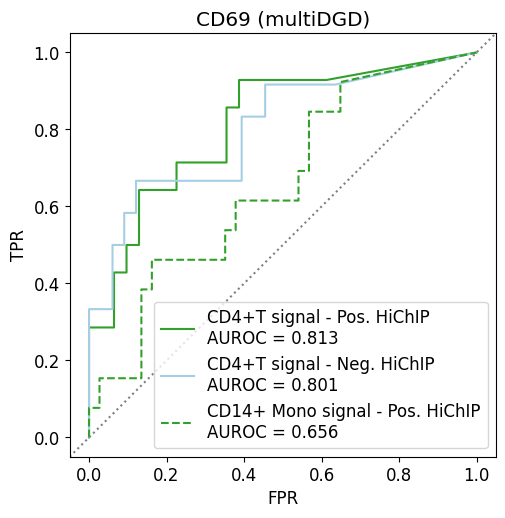

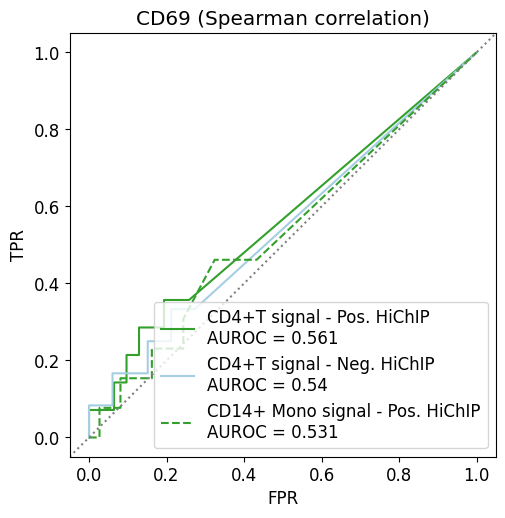

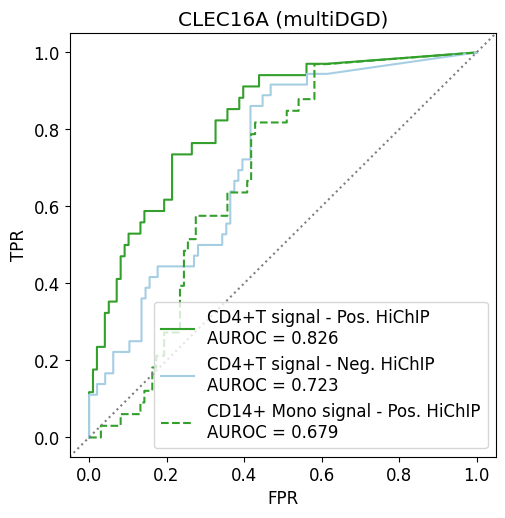

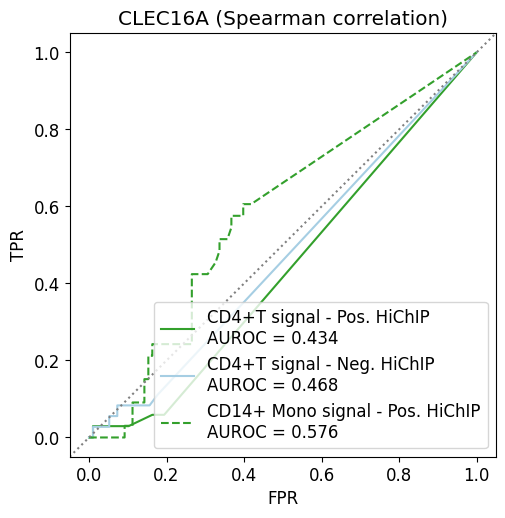

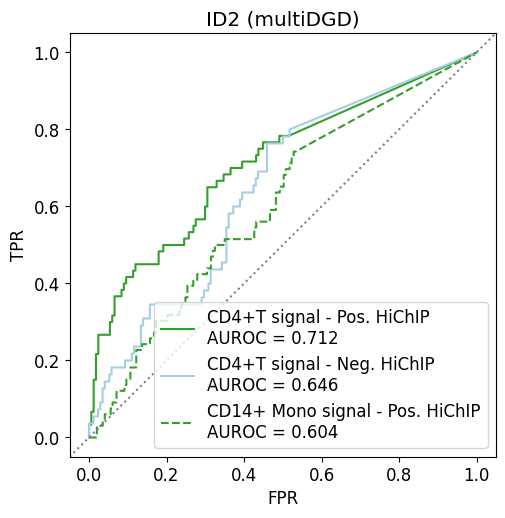

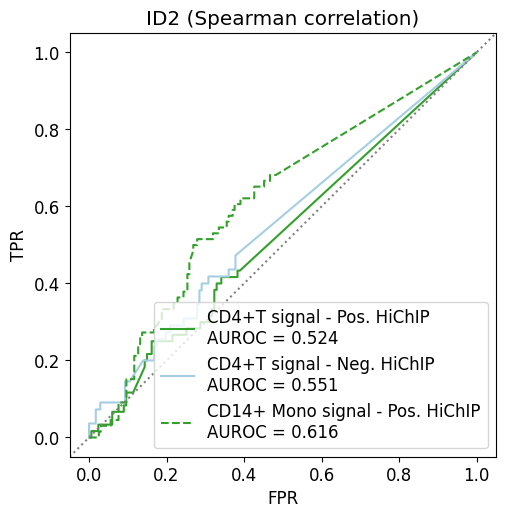

In [396]:
for gene in ['CD69', 'CLEC16A', 'ID2']:
    corr_df = pd.read_csv(outdir + f'{gene}_hg38_baseline_correlation.csv')
    dgd_df = pd.read_csv(outdir + f'{gene}_hg38_hichip_dgd_aligned_locations.csv')
    dgd_df = pd.concat([dgd_df, corr_df])
    dgd_df['gene_name'] = gene

    plot_roc(dgd_df[dgd_df.method != 'Spearman']);
    plt.title(f'{gene} (multiDGD)');
    plt.savefig(figdir + f'{gene}_ROC_multiDGD.pdf');
    plt.show();

    plot_roc(dgd_df[dgd_df.method != 'multiDGD']);
    plt.title(f'{gene} (Spearman correlation)');
    plt.savefig(figdir + f'{gene}_ROC_corr.pdf');
    plt.show()